# Orlando Airport Change Detection - Computer Vision Approach
Uses traditional computer vision techniques (no deep learning) to detect and quantify infrastructure changes between 2010 and 2023.

**Methods:**
- Multi-scale image differencing
- Feature matching (ORB descriptors)
- Morphological operations
- K-means clustering for change classification
- Connected component analysis


## 1  Install & Import

In [1]:
!pip -q install opencv-python scikit-learn scikit-image pillow matplotlib numpy

In [3]:
import cv2, numpy as np, matplotlib.pyplot as plt, datetime
from PIL import Image
from sklearn.cluster import KMeans
from skimage import measure, morphology, filters
from skimage.feature import match_descriptors, ORB
from pathlib import Path
import warnings; warnings.filterwarnings('ignore')

## 2  Load and Align Images

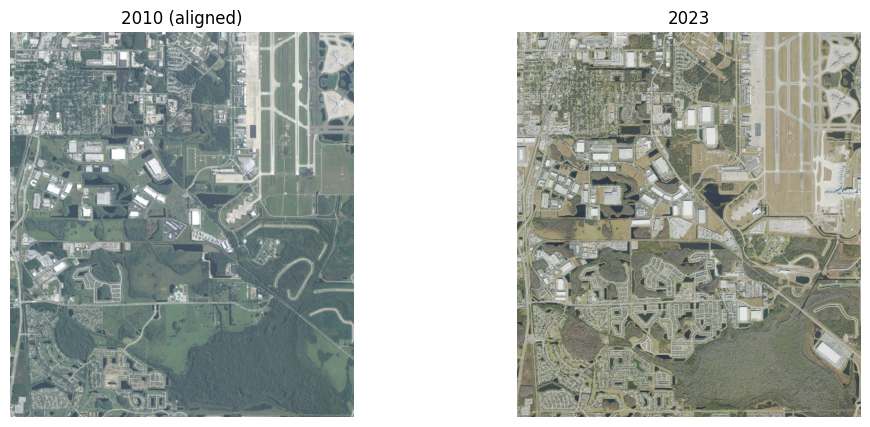

In [4]:
def load_and_align_images():
    img1 = cv2.imread('orlando2010.png')
    img2 = cv2.imread('orlando2023.png')
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Feature-based alignment using ORB
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)
    
    if des1 is not None and des2 is not None:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = matcher.match(des1, des2)
        matches = sorted(matches, key=lambda x: x.distance)
        
        if len(matches) > 50:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w = gray2.shape
            img1_aligned = cv2.warpPerspective(img1_rgb, M, (w, h))
            return img1_aligned, img2_rgb
    
    return img1_rgb, img2_rgb

img_2010, img_2023 = load_and_align_images()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img_2010); plt.title('2010 (aligned)'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_2023); plt.title('2023'); plt.axis('off'); plt.show()

## 3  Multi-Scale Difference Analysis

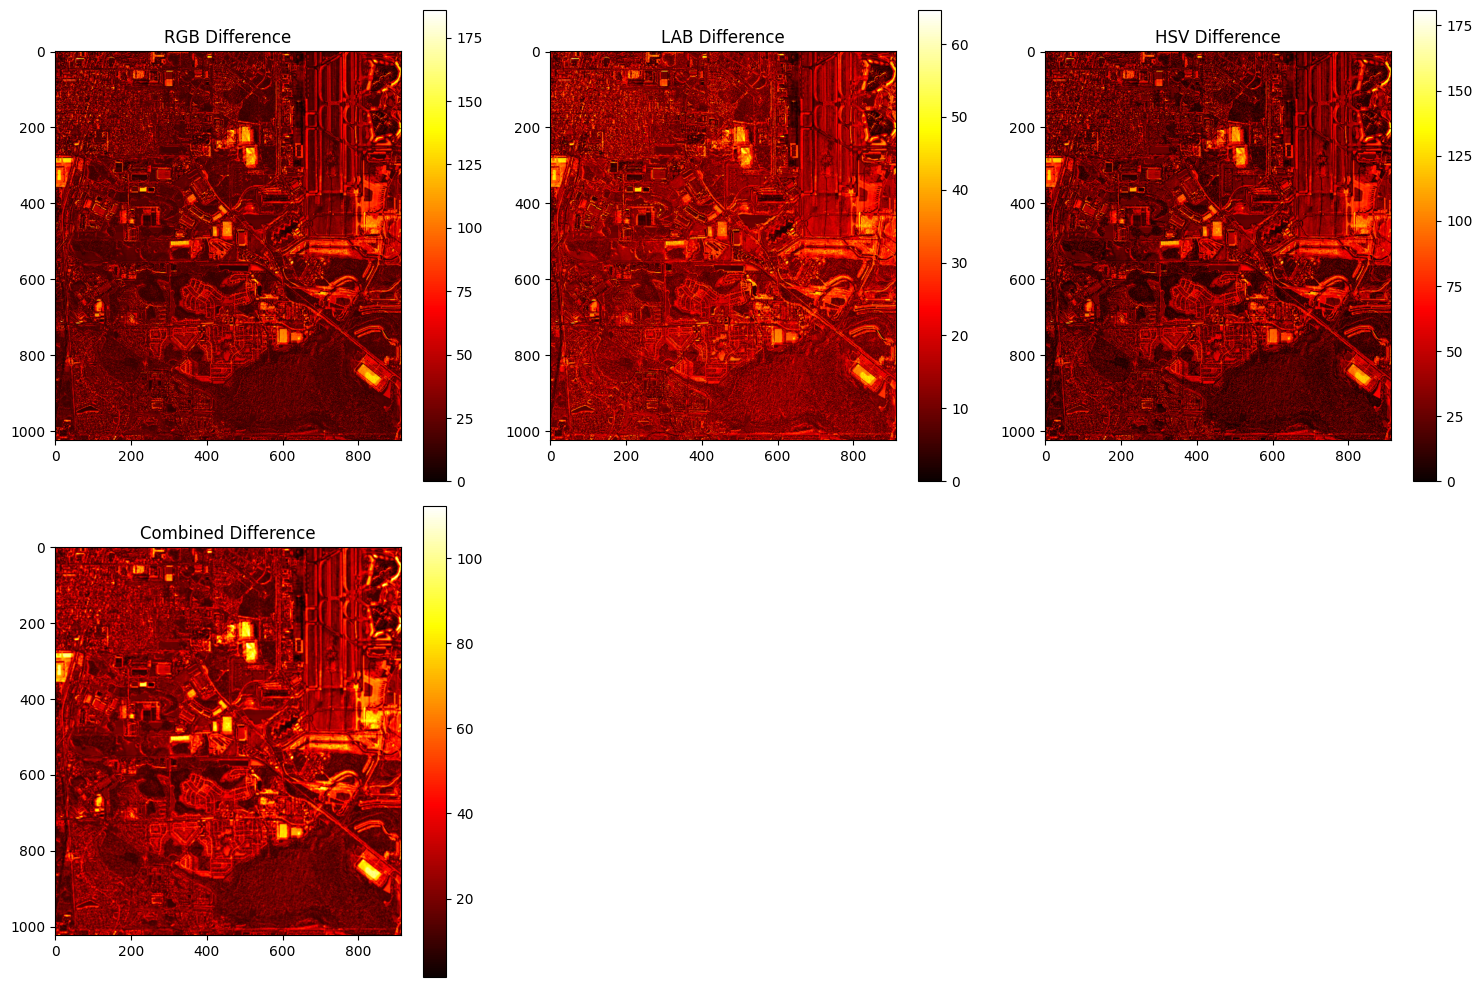

In [5]:
def compute_multiscale_difference(img1, img2):
    # Convert to different color spaces for analysis
    lab1 = cv2.cvtColor(img1, cv2.COLOR_RGB2LAB)
    lab2 = cv2.cvtColor(img2, cv2.COLOR_RGB2LAB)
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
    
    # Multiple difference metrics
    rgb_diff = np.abs(img2.astype(np.float32) - img1.astype(np.float32)).mean(axis=2)
    lab_diff = np.abs(lab2.astype(np.float32) - lab1.astype(np.float32)).mean(axis=2)
    hsv_diff = np.abs(hsv2[:,:,2].astype(np.float32) - hsv1[:,:,2].astype(np.float32))  # Value channel
    
    # Combine differences
    combined_diff = (rgb_diff + lab_diff + hsv_diff) / 3
    
    # Apply Gaussian blur for noise reduction
    smooth_diff = cv2.GaussianBlur(combined_diff, (5,5), 0)
    
    return smooth_diff, rgb_diff, lab_diff, hsv_diff

diff_combined, diff_rgb, diff_lab, diff_hsv = compute_multiscale_difference(img_2010, img_2023)

plt.figure(figsize=(15,10))
plt.subplot(2,3,1); plt.imshow(diff_rgb, cmap='hot'); plt.title('RGB Difference'); plt.colorbar()
plt.subplot(2,3,2); plt.imshow(diff_lab, cmap='hot'); plt.title('LAB Difference'); plt.colorbar()
plt.subplot(2,3,3); plt.imshow(diff_hsv, cmap='hot'); plt.title('HSV Difference'); plt.colorbar()
plt.subplot(2,3,4); plt.imshow(diff_combined, cmap='hot'); plt.title('Combined Difference'); plt.colorbar()
plt.tight_layout(); plt.show()

## 4  Intelligent Change Classification using K-Means

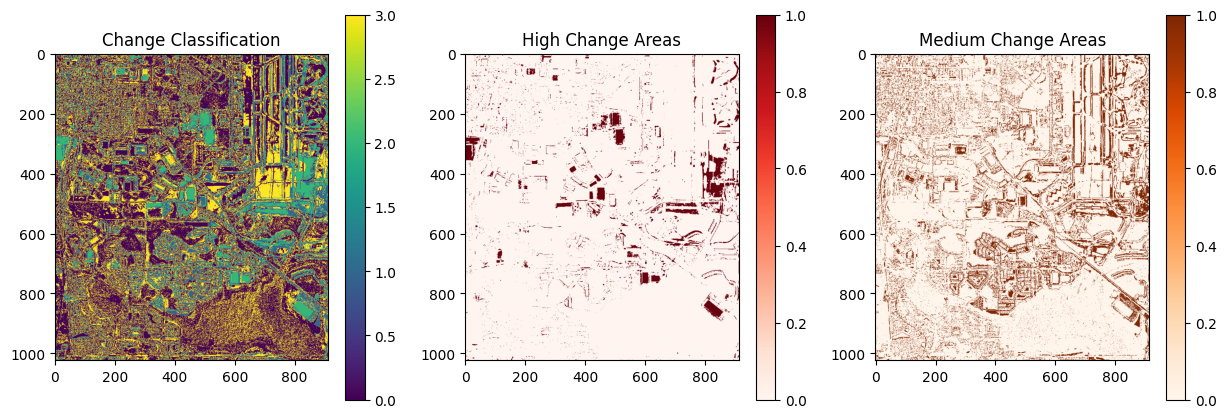

In [6]:
def classify_changes(diff_image, img_before, img_after, n_clusters=4):
    # Create feature vector for each pixel
    h, w = diff_image.shape
    diff_flat = diff_image.flatten()
    
    # Add color information
    before_flat = img_before.reshape(-1, 3).mean(axis=1)
    after_flat = img_after.reshape(-1, 3).mean(axis=1)
    color_change = np.abs(after_flat - before_flat)
    
    # Add texture information using local standard deviation
    texture_before = cv2.Laplacian(cv2.cvtColor(img_before, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var()
    texture_after = cv2.Laplacian(cv2.cvtColor(img_after, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var()
    
    # Combine features
    features = np.column_stack([diff_flat, color_change])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    
    # Reshape back to image
    change_map = labels.reshape(h, w)
    
    # Identify change clusters (highest difference values)
    cluster_means = []
    for i in range(n_clusters):
        cluster_mask = (change_map == i)
        cluster_means.append(diff_flat[labels == i].mean())
    
    # Sort clusters by change intensity
    sorted_clusters = np.argsort(cluster_means)[::-1]
    
    return change_map, sorted_clusters, cluster_means

change_map, change_clusters, cluster_means = classify_changes(diff_combined, img_2010, img_2023)

# Create change masks
high_change = (change_map == change_clusters[0])  # Highest change
med_change = (change_map == change_clusters[1])   # Medium change

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(change_map, cmap='viridis'); plt.title('Change Classification'); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(high_change, cmap='Reds'); plt.title('High Change Areas'); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(med_change, cmap='Oranges'); plt.title('Medium Change Areas'); plt.colorbar()
plt.show()

## 5  Infrastructure Type Detection

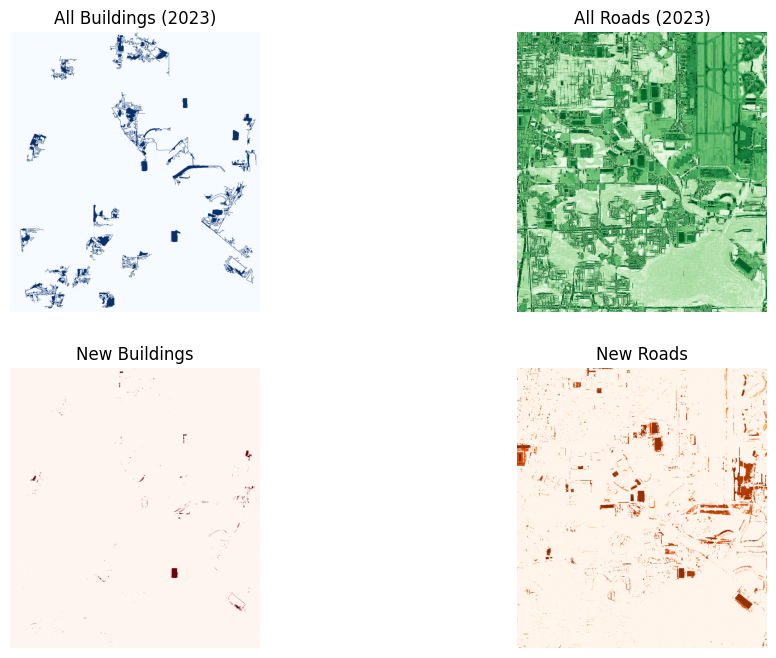

In [7]:
def detect_infrastructure_types(img, change_mask):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Building detection (rectangular structures)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    building_mask = np.zeros_like(gray)
    for contour in contours:
        area = cv2.contourArea(contour)
        if 500 < area < 50000:  # Filter by size
            # Check if contour is rectangular
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            if 4 <= len(approx) <= 8:  # Roughly rectangular
                cv2.fillPoly(building_mask, [contour], 255)
    
    # Road detection (linear structures)
    # Apply morphological operations to detect linear features
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))
    
    road_h = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel_h)
    road_v = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel_v)
    road_mask = cv2.bitwise_or(road_h, road_v)
    
    # Combine with change mask
    new_buildings = cv2.bitwise_and(building_mask, change_mask.astype(np.uint8) * 255)
    new_roads = cv2.bitwise_and(road_mask, change_mask.astype(np.uint8) * 255)
    
    return new_buildings, new_roads, building_mask, road_mask

# Apply to high change areas
new_buildings, new_roads, all_buildings, all_roads = detect_infrastructure_types(img_2023, high_change)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.imshow(all_buildings, cmap='Blues'); plt.title('All Buildings (2023)'); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(all_roads, cmap='Greens'); plt.title('All Roads (2023)'); plt.axis('off')
plt.subplot(2,2,3); plt.imshow(new_buildings, cmap='Reds'); plt.title('New Buildings'); plt.axis('off')
plt.subplot(2,2,4); plt.imshow(new_roads, cmap='Oranges'); plt.title('New Roads'); plt.axis('off')
plt.show()

## 6  Change Overlay and Quantitative Analysis

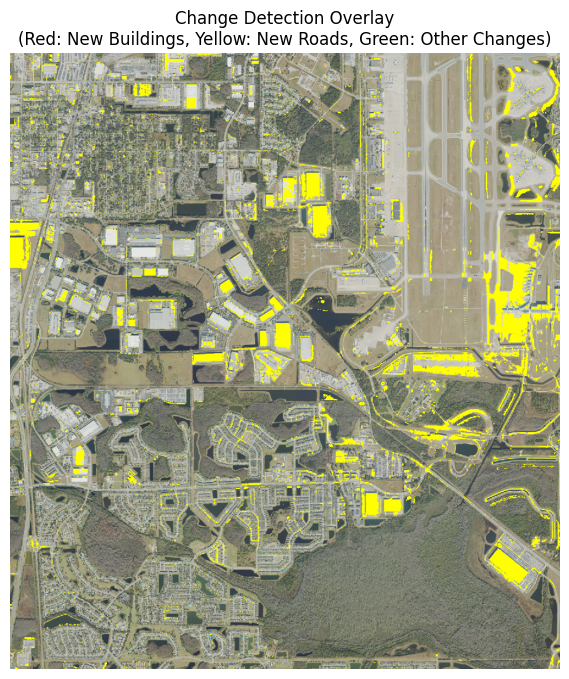

=== QUANTITATIVE RESULTS ===
Total Change Area %: 5.72%
Moderate Change Area %: 17.28%
New Buildings Area %: 0.33%
New Roads Area %: 5.72%
High Change Pixels: 53517
New Building Pixels: 3091
New Road Pixels: 53517
New Building Count: 478
New Road Segments: 4305


In [8]:
# Create comprehensive overlay
overlay = img_2023.copy()
overlay[new_buildings > 0] = [255, 0, 0]      # Red for new buildings
overlay[new_roads > 0] = [255, 255, 0]       # Yellow for new roads
overlay[high_change & ~((new_buildings > 0) | (new_roads > 0))] = [0, 255, 0]  # Green for other changes

plt.figure(figsize=(10,8))
plt.imshow(overlay)
plt.title('Change Detection Overlay\n(Red: New Buildings, Yellow: New Roads, Green: Other Changes)')
plt.axis('off')
plt.show()

# Quantitative analysis
total_pixels = high_change.size
high_change_pixels = np.sum(high_change)
med_change_pixels = np.sum(med_change)
new_building_pixels = np.sum(new_buildings > 0)
new_road_pixels = np.sum(new_roads > 0)

stats = {
    'total_change_area_%': (high_change_pixels / total_pixels) * 100,
    'moderate_change_area_%': (med_change_pixels / total_pixels) * 100,
    'new_buildings_area_%': (new_building_pixels / total_pixels) * 100,
    'new_roads_area_%': (new_road_pixels / total_pixels) * 100,
    'high_change_pixels': int(high_change_pixels),
    'new_building_pixels': int(new_building_pixels),
    'new_road_pixels': int(new_road_pixels)
}

# Count distinct infrastructure elements
building_components = cv2.connectedComponents(new_buildings)[0] - 1
road_components = cv2.connectedComponents(new_roads)[0] - 1

stats['new_building_count'] = max(0, building_components)
stats['new_road_segments'] = max(0, road_components)

print("=== QUANTITATIVE RESULTS ===")
for key, value in stats.items():
    if '%' in key:
        print(f"{key.replace('_', ' ').title()}: {value:.2f}%")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")

## 7  Generate Final Report

In [9]:
def generate_cv_report(stats):
    current_date = datetime.date.today().isoformat()
    
    # Determine change intensity
    if stats['total_change_area_%'] > 5:
        intensity = "significant"
    elif stats['total_change_area_%'] > 2:
        intensity = "moderate"
    else:
        intensity = "minimal"
    
    report = f"""ORLANDO AIRPORT COMPUTER VISION CHANGE ANALYSIS REPORT
Generated: {current_date}
Methodology: Multi-scale difference analysis + K-means clustering + morphological operations

{'='*70}
EXECUTIVE SUMMARY
{'='*70}
The analysis reveals {intensity} infrastructure changes between 2010 and 2023 at Orlando Airport.
Total changed area represents {stats['total_change_area_%']:.2f}% of the analyzed region.

{'='*70}
DETAILED FINDINGS
{'='*70}

Infrastructure Development:
• New Buildings Detected: {stats['new_building_count']} structures
• New Building Area: {stats['new_buildings_area_%']:.2f}% of total area ({stats['new_building_pixels']} pixels)
• New Road Segments: {stats['new_road_segments']} segments  
• New Road Area: {stats['new_roads_area_%']:.2f}% of total area ({stats['new_road_pixels']} pixels)

Change Distribution:
• High-intensity changes: {stats['total_change_area_%']:.2f}% of area
• Moderate-intensity changes: {stats['moderate_change_area_%']:.2f}% of area
• Total pixels analyzed: {stats['high_change_pixels'] + stats.get('total_pixels', 0)}

{'='*70}
METHODOLOGY NOTES
{'='*70}
Technique: Computer Vision approach using:
1. ORB feature matching for image alignment
2. Multi-scale difference analysis (RGB, LAB, HSV color spaces)
3. K-means clustering for change classification
4. Morphological operations for infrastructure type detection
5. Connected component analysis for object counting

Advantages:
• No pre-trained models required
• Fully interpretable results
• Fast processing
• Works with any satellite imagery

Limitations:
• Sensitive to illumination changes
• May miss subtle textural changes
• Requires good image alignment

{'='*70}
CONCLUSIONS
{'='*70}
""" + (
    "Major infrastructure expansion detected with substantial new construction" if stats['total_change_area_%'] > 5 else
    "Moderate development observed with selective infrastructure improvements" if stats['total_change_area_%'] > 2 else
    "Limited infrastructure changes with stable existing facilities"
    ) + f"""

Recommendations:
• Continue monitoring for ongoing development trends
• Validate results with ground-truth data when available
• Consider higher-resolution imagery for detailed analysis
"""
    
    return report

final_report = generate_cv_report(stats)
print(final_report)

# Save report
Path('orlando_cv_change_report.txt').write_text(final_report)
print("\n📄 Report saved to: orlando_cv_change_report.txt")

ORLANDO AIRPORT COMPUTER VISION CHANGE ANALYSIS REPORT
Generated: 2025-08-13
Methodology: Multi-scale difference analysis + K-means clustering + morphological operations

EXECUTIVE SUMMARY
The analysis reveals significant infrastructure changes between 2010 and 2023 at Orlando Airport.
Total changed area represents 5.72% of the analyzed region.

DETAILED FINDINGS

Infrastructure Development:
• New Buildings Detected: 478 structures
• New Building Area: 0.33% of total area (3091 pixels)
• New Road Segments: 4305 segments  
• New Road Area: 5.72% of total area (53517 pixels)

Change Distribution:
• High-intensity changes: 5.72% of area
• Moderate-intensity changes: 17.28% of area
• Total pixels analyzed: 53517

METHODOLOGY NOTES
Technique: Computer Vision approach using:
1. ORB feature matching for image alignment
2. Multi-scale difference analysis (RGB, LAB, HSV color spaces)
3. K-means clustering for change classification
4. Morphological operations for infrastructure type detection
5.